# Starbucks Capstone Challenge: Predict users which are most likely to buy product using offers in Starbucks App.

## 1. Introduction

In this notebook I'm going to answer a question regarding the use of offers in Starbucks App data. 

        Which are the main characteristics to predict if an user will take an offer in the App?

According to this question, I will use data provided by Udacity to complete mi DataScience Nanodegree. This data contains simulated data that are based on Starbucks App real information. This info contains a 714 days time period of offer sending to differents customers every few days, also we have demographical information about users app and the transactional events ocurrieng on the app. With this data I'm going to predict the most important variables and user atributes to predict if the customer will buy a product if a send them an offer.

The data is contained in three files:

- portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
- profile.json - demographic data for each customer
- transcript.json - records for transactions, offers received, offers viewed, and offers completed

## 2. Package Import and Data Loading

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import tree
# from sklearn.tree import plot_tree

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 3. Data Exploration

In [2]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)

### a. Portfolio.json

This is the schema provided by Udacity:
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


As we can see first, the channels are a list so we need to transform into a dummy variable.

Let's see if the variables dtypes are equal to the schema.

In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


We can observe that there is not null values in the dataframe. 

Now Let's see the distribution of the numeric variables.

In [5]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [6]:
portfolio.offer_type.value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

There are 10 differents offers: 2 Buy One Get One, 4 Discounts and 2 informational.

Text(0,0.5,'duration (days)')

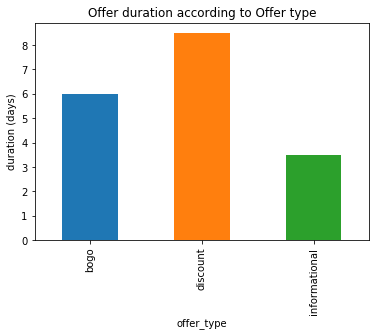

In [7]:
portfolio.groupby('offer_type')['duration'].mean().plot.bar()
plt.title('Offer duration according to Offer type')
plt.ylabel('duration (days)')

Text(0,0.5,'dollars')

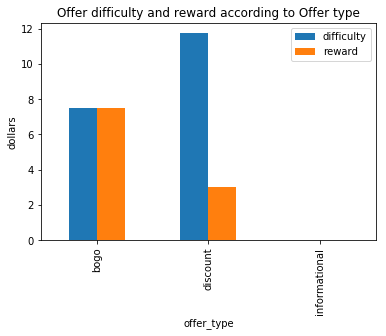

In [8]:
portfolio.groupby('offer_type')[['difficulty','reward']].mean().plot.bar()
plt.title('Offer difficulty and reward according to Offer type')
plt.ylabel('dollars')

### b. Profile.json
This is the Schema Provided by Udacity:
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [9]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


Column became_member_on needs to be transformed to a timestamp. And gender has None values which tells us that are non binary customers

In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In this case we can obvserve that there is some null values in gender and income columns

Let's see gender distribution

In [11]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

Text(0.5,0,'Gender')

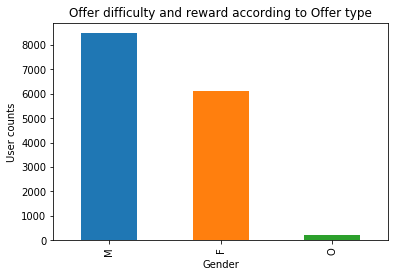

In [12]:
profile.gender.value_counts().plot.bar()
plt.title('Offer difficulty and reward according to Offer type')
plt.ylabel('User counts')
plt.xlabel('Gender')

Let's see income histogram

Text(0.5,0,'Income')

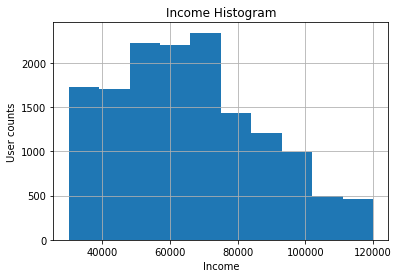

In [13]:
profile.income.hist()
plt.title('Income Histogram')
plt.ylabel('User counts')
plt.xlabel('Income')

In [14]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


This 118 values must be an mistake. It could be a 18 years value but it was mistyped. Let's see the histogram of the age variable.

Text(0.5,0,'Age')

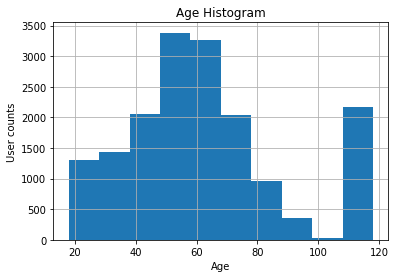

In [15]:
profile.age.hist()
plt.title('Age Histogram')
plt.ylabel('User counts')
plt.xlabel('Age')

In [16]:
profile.age.value_counts().head(10)

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
Name: age, dtype: int64

118 years old of age are the most commmon value, we can check the gender, income and when they became members.

In [17]:
profile[profile['age']==118].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [18]:
profile[profile['age']==118].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
age                 2175 non-null int64
became_member_on    2175 non-null int64
gender              0 non-null object
id                  2175 non-null object
income              0 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 102.0+ KB


In [19]:
profile[profile['age']==118]['gender'].nunique()

0

In [20]:
profile[profile['age']==118].gender.value_counts()

Series([], Name: gender, dtype: int64)

We can drop these values because the ids doesn't have income information or gender.

In [21]:
profile.id.nunique()

17000

There are no duplicated ids

### c. Transcript.json

This is the Schema provided by udacity:
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [22]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


Value has concatenated offer id which is need to be merged with portfolio dataset to know the offer

In [23]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


There is not null values

In [24]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

Text(0.5,0,'Event type')

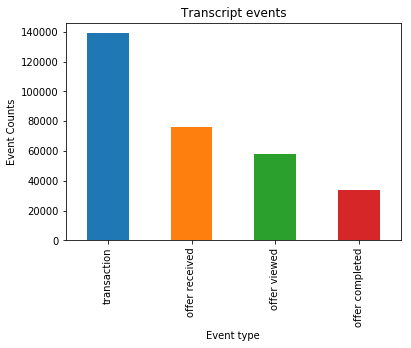

In [25]:
transcript.event.value_counts().plot.bar()
plt.title('Transcript events')
plt.ylabel('Event Counts')
plt.xlabel('Event type')

There are more transactions than offer related events

In [26]:
transcript.person.nunique()

17000

There is the same amount of people in transactions dataset that in demographics

In [27]:
transcript[transcript['event'] == 'transaction'].head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [28]:
transcript[transcript['event'] == 'offer viewed'].head()

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [29]:
transcript[transcript['event'] == 'offer completed'].head()

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


We can observe that events *Offer Viewed* and *Offer Recieved* has in value a sligth difference in 'Offer id' in comparison to *Offer Completed* which has 'Offer_id' value. This must be changed to evalue properly the further steps to analyze the offer events. 

## 4. Data Cleaning

### a. Portfolio.json

In this dataset, we need to change the id column name to offer_id to get a better name on merging the tables

In [30]:
portfolio.rename(columns = {'id':'offer_id'}, inplace = True)

Also, it could be a great idea to expand the channels columns to generate a dummy variable for each used channel

In [31]:
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


### b. Profile.json

First we drop 118 age records

In [32]:
profile = profile[profile['age'] != 118]
profile.head()

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


Rename id to customer_id

In [33]:
profile.rename(columns = {'id':'customer_id'}, inplace = True)

In [34]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
customer_id         14825 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


Now that there isn't null values, we proceed to transform became_member_on column to timestamp

In [35]:
profile.became_member_on = pd.to_datetime(profile.became_member_on, format="%Y%m%d")

### c. Transcript.json

In [36]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


 first were goind to split the columns contained in the value column

In [37]:
value_series = transcript['value'].apply(pd.Series)

In [38]:
transcript = pd.concat([transcript, value_series], axis = 1)

In [39]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 8 columns):
event       306534 non-null object
person      306534 non-null object
time        306534 non-null int64
value       306534 non-null object
offer id    134002 non-null object
amount      138953 non-null float64
offer_id    33579 non-null object
reward      33579 non-null float64
dtypes: float64(2), int64(1), object(5)
memory usage: 18.7+ MB


We have offer_id and offer id column, so we need to join all this information

In [40]:
transcript['offer_id'] = np.where(transcript['offer_id'].isnull() & transcript['offer id'].notnull(),
                                  transcript['offer id'],
                                  transcript['offer_id'])

In [41]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 8 columns):
event       306534 non-null object
person      306534 non-null object
time        306534 non-null int64
value       306534 non-null object
offer id    134002 non-null object
amount      138953 non-null float64
offer_id    167581 non-null object
reward      33579 non-null float64
dtypes: float64(2), int64(1), object(5)
memory usage: 18.7+ MB


In [42]:
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


finally, we drop value and offer id columns

In [43]:
transcript.drop(columns = ['value','offer id'], inplace = True)

In [44]:
transcript.head()

,event,person,time,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


## 5. Project Definitions

First fo all, we wanna know the demographic variables which determine if a customer will buy a product, having recieved an offer. According to this, we need to define the effectiveness of the offer sent in the app. 

In [45]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

We have 4 events ins transcription dataset: Transaction, Offer Recieved, Offer Viewed and Offer Completed. Let's take a look at some random id and see their tranctional behaviour.

In [46]:
transcript[transcript['person']=='9fa9ae8f57894cc9a3b8a9bbe0fc1b2f']

,event,person,time,amount,offer_id,reward
36,offer received,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
12656,offer viewed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,NaN
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
27850,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,42,21.55,NaN,NaN
44327,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,114,32.87,NaN,NaN
51350,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,156,19.99,NaN,NaN
65854,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,168,20.97,NaN,NaN
81403,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,204,31.09,NaN,NaN
110866,offer received,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,336,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN


We can assume that normal funnel of an effective offer are **Offer Recieved - Offer Viewed - Transaction - Offer Completed** but let's merge portfolio dataset to get more information.

In [47]:
transcript_merged = transcript.merge(portfolio, how = 'left', on = 'offer_id')

In [48]:
transcript_merged.head()

,event,person,time,amount,offer_id,reward_x,channels,difficulty,duration,offer_type,reward_y
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,"[web, email, mobile]",5.0,7.0,bogo,5.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,"[web, email]",20.0,10.0,discount,5.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,"[web, email, mobile]",10.0,7.0,discount,2.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,"[web, email, mobile, social]",10.0,10.0,discount,2.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,"[web, email, mobile, social]",10.0,5.0,bogo,10.0


In [49]:
transcript_merged.groupby(['event','offer_type'])['event'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: event, dtype: int64

We can observe that informational offers doesn't get count in ´offer complete´ event. According to this, we can make a definition of effective offer if the customer does the following two paths.

**1. Effective Customers**
* *Offer Recieved - Offer Viewed - Transaction - Offer Completed* (BOGO/Discount Offers)
* *Offer Recieved - Offer Viewed - Transaction* (Informational Offers)

On the other hand, we must categorize the othe type or order of events as ineffective offers. We can define two types non effective offers: 

**2. Loyal customers:** those who buy products without getting any offer or having noticed about the offer.
* *Transaction* 
* *Transaction - Offer Completed*
* *Transaction - Offer Completed - Offer Viewed*
* *Offer Recieved - Transaction - Offer Completed - Offer Viewed*
* *Offer Recieved - Transaction - Offer Completed*

**3. Non Effective customers:** those who recieves the offer but doesn't buy anything. 
* *Offer Recieved - Offer Viewed*
* *Offer Recieved*

With this three groups, we can focus on effective customers to predict the most important variables in order to send the offers to this type of customers. With the second group in financial terms, we must not send them any offer because they are already loyal so we can get higher profits with them. Finally the last group will be the least important group to focus. This group doesn's buy even having an offer.

## 6. Data Wrangling

First of all, we are going to identify the effective customers. We need to order all the events by person and in ascendent time.

In [50]:
transcript=transcript.sort_values(['person','time'])

In [51]:
transcript.head()

,event,person,time,amount,offer_id,reward
55972,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
89291,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN
113605,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,3f207df678b143eea3cee63160fa8bed,NaN
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,3f207df678b143eea3cee63160fa8bed,NaN


In [52]:
transaction_viewed = transcript[['time','offer_id','person','event']][(transcript['event']=='transaction') |
                                                                      (transcript['event']=='offer viewed')].groupby(['person','offer_id']).ffill()
transaction_viewed['offer_id'] = transaction_viewed['offer_id'].ffill()

In [53]:
transaction_viewed.head()

,person,offer_id,time,event
77705,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192,offer viewed
89291,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,228,transaction
139992,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372,offer viewed
168412,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,414,transaction
187554,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456,offer viewed


Merge the transaction_viewed dataset and transcript to get the last offer viewed by the customer

In [54]:
transcript=transcript.merge(transaction_viewed,how='left',on=['person','time','event'])

In [55]:
transcript.head()

,event,person,time,amount,offer_id_x,reward,offer_id_y
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,3f207df678b143eea3cee63160fa8bed,NaN,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,3f207df678b143eea3cee63160fa8bed,NaN,3f207df678b143eea3cee63160fa8bed


In [56]:
transcript['offer_id']=np.where(transcript['offer_id_x'].isnull(),transcript['offer_id_y'],transcript['offer_id_x'])
transcript.drop(columns=['offer_id_x','offer_id_y'], inplace = True)

In [57]:
transcript = transcript.merge(portfolio,how='left',on='offer_id')

In [58]:
transcript.drop(columns='reward_x', inplace = True)
transcript.rename(columns={'reward_y':'reward'},inplace=True)

In [59]:
transcript.head()

,event,person,time,amount,offer_id,channels,difficulty,duration,offer_type,reward
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0


We have the transaction and the last offer_id asociated, now its easier to get the effective transactions

Now, we are going to get all the events of viewed offer, the transaction and the offer completed for a BOGO or a discount

In [60]:
transaction_viewd_completed=transcript[(transcript['event']=='offer viewed') | 
                                                (transcript['event']=='transaction')  | 
                                                (transcript['event']=='offer completed')].copy()

Using pd.shift, we extract the previous offer_id

In [61]:
transaction_viewd_completed['prev_offer_id'] = transaction_viewd_completed.groupby(['person','offer_id'])['offer_id'].shift()

In [62]:
transaction_viewd_completed.head()

,event,person,time,amount,offer_id,channels,difficulty,duration,offer_type,reward,prev_offer_id
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0,NaN
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0,5a8bc65990b245e5a138643cd4eb9837
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0,NaN
6,transaction,0009655768c64bdeb2e877511632db8f,414,8.57,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0,3f207df678b143eea3cee63160fa8bed
7,offer completed,0009655768c64bdeb2e877511632db8f,414,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,bogo,5,NaN


We evaluate if the transaction are asociated with the awareness of the offer

In [63]:
transaction_viewd_completed['offer_completed']=np.where(transaction_viewd_completed['prev_offer_id']==transaction_viewd_completed['offer_id'],1,0)

Generate a copy of only events of offers recieved

In [64]:
off_received=transcript[transcript['event']=='offer received'].copy()

#Generate columns to be equal
off_received['offer_completed']=np.nan
off_received['prev_offer_id']=np.nan

append datasets offers 

In [65]:
transcript=off_received.append(transaction_viewd_completed)

#sort by person_id and time
transcript=transcript.sort_values(['person','time'])

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [66]:
transcript.head()

,amount,channels,difficulty,duration,event,offer_completed,offer_id,offer_type,person,prev_offer_id,reward,time
0,NaN,"[email, mobile, social]",0,3,offer received,NaN,5a8bc65990b245e5a138643cd4eb9837,informational,0009655768c64bdeb2e877511632db8f,NaN,0,168
1,NaN,"[email, mobile, social]",0,3,offer viewed,0.0,5a8bc65990b245e5a138643cd4eb9837,informational,0009655768c64bdeb2e877511632db8f,NaN,0,192
2,22.16,"[email, mobile, social]",0,3,transaction,1.0,5a8bc65990b245e5a138643cd4eb9837,informational,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,228
3,NaN,"[web, email, mobile]",0,4,offer received,NaN,3f207df678b143eea3cee63160fa8bed,informational,0009655768c64bdeb2e877511632db8f,NaN,0,336
4,NaN,"[web, email, mobile]",0,4,offer viewed,0.0,3f207df678b143eea3cee63160fa8bed,informational,0009655768c64bdeb2e877511632db8f,NaN,0,372


Now having the lastest offer_id in asociated with all transactions, we can search more easily all the customers groups. Now we can asume that all offer_completed = 1 are the efective transactions.

We are going to create 3 different datasets according to the offer type.

In [67]:
offers = list(transcript.offer_type.unique())
offers

['informational', 'bogo', 'discount']

In [68]:
offer_informational = transcript[transcript['offer_type'] == 'informational'].copy()
offer_bogo = transcript[transcript['offer_type'] == 'bogo'].copy()
offer_discount = transcript[transcript['offer_type'] == 'discount'].copy()

With bogo and discount offers we can filter by getting offer_completed = 1 and getting those clients who where effective. With informational offers we need to validate if transaction time are between offer duration. 

With informational offers will look later because we need to evaluate if the transactions are between the offer duration.

### a.Effective Customers:
#### BOGO / Discount Offers

In [69]:
def efective_customers(df):
    """
    Filter dataframe to get only effective transactions, grouped by user and offer id
    
    INPUTS:
        - df: original dataframe
    
    OUTPUTS:
        - filtered dataframe
    """
    
    ef_customers = df[['person','offer_id']][(df['offer_completed']==1) & (df['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()
    return ef_customers

get the effective transtactions of bogo and discount offers

In [70]:
ef_customers_bogo = efective_customers(offer_bogo)
ef_customers_discount = efective_customers(offer_discount)

In [71]:
ef_customers_bogo.head()

,person,offer_id
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d


In [72]:
ef_customers_discount.head()

,person,offer_id
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4
3,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2
4,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4


### b. Loyal customers
#### BOGO / Discount Offers
Loyal customers can be defined as those clients who purchased products without knowing there was an active offer.

In [73]:
def loyal_customers(df):
    """
    Filter dataframe to get only non effective transactions but getting the offer or having a transaction,
    without having recieved the offer or viewing it. Grouped by user and offer id
    
    INPUTS:
        - df: original dataframe
    
    OUTPUTS:
        - filtered dataframe
    """
    
    ef_customers = df[['person','offer_id']][(df['offer_completed']!=1) & (df['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()
    return ef_customers

In [74]:
loyal_bogo = loyal_customers(offer_bogo)
loyal_discount = loyal_customers(offer_discount)

In [75]:
loyal_bogo.head()

,person,offer_id
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d
1,004c5799adbf42868b9cff0396190900,ae264e3637204a6fb9bb56bc8210ddfd
2,005500a7188546ff8a767329a2f7c76a,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,00715b6e55c3431cb56ff7307eb19675,4d5c57ea9a6940dd891ad53e9dbe8da0
4,00715b6e55c3431cb56ff7307eb19675,ae264e3637204a6fb9bb56bc8210ddfd


In [76]:
loyal_discount.head()

,person,offer_id
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4
2,003d66b6608740288d6cc97a6903f4f0,0b1e1539f2cc45b7b9fa7c272da2e1d7
3,0056df74b63b4298809f0b375a304cf4,0b1e1539f2cc45b7b9fa7c272da2e1d7
4,0056df74b63b4298809f0b375a304cf4,2298d6c36e964ae4a3e7e9706d1fb8c2


### c. Non Efective Customers
#### BOGO / Discount /Informational  Offers
Non efective customers are those who doesn't have any transaction having recieved any offer or even viewed the offer.

In [77]:
def non_efective_customers(df):
    """
    First of all, get all the id_users that make transactions and them excluding them from all the id who gets offers. 
    Keep only the customers who doesn't buy anything but recieved some offer.
    
    INPUTS:
        - df: original dataframe
    
    OUTPUTS:
        - filtered dataframe
    """
    #customer_id who bougth anything
    customers_who_bougth = df[['person','offer_id']][(df['event']=='transaction') | (df['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()
    
    #customer_id who recieved any offer
    customers_who_get_offers = df[['person','offer_id']][df['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()
    
    #Left join for customers_who_get_offers
    merged_customers = customers_who_get_offers.merge(customers_who_bougth, how='left', on=['person','offer_id'], indicator=True)
    
    #drop id_customers who bought
    merged_customers =  merged_customers[merged_customers['_merge']=='left_only']
    
    #Merge again with transcript to get the offers events
    non_ef_customers = merged_customers.drop(columns='_merge')
#     non_ef_customers = merged_customers.merge(transcript, how='left', on=['person','offer_id'])
    
    
    return non_ef_customers

In [78]:
non_ef_customers_bogo = non_efective_customers(offer_bogo)
non_ef_customers_discount = non_efective_customers(offer_discount)
non_ef_customers_informational = non_efective_customers(offer_informational)

In [79]:
non_ef_customers_bogo.head()

,person,offer_id
4,0020c2b971eb4e9188eac86d93036a77,ae264e3637204a6fb9bb56bc8210ddfd
13,0063def0f9c14bc4805322a488839b32,9b98b8c7a33c4b65b9aebfe6a799e6d9
20,00857b24b13f4fe0ad17b605f00357f5,9b98b8c7a33c4b65b9aebfe6a799e6d9
22,00857b24b13f4fe0ad17b605f00357f5,f19421c1d4aa40978ebb69ca19b0e20d
23,008d7088107b468893889da0ede0df5c,4d5c57ea9a6940dd891ad53e9dbe8da0


In [80]:
non_ef_customers_discount.head()

,person,offer_id
8,00426fe3ffde4c6b9cb9ad6d077a13ea,0b1e1539f2cc45b7b9fa7c272da2e1d7
9,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5
13,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5
16,0063def0f9c14bc4805322a488839b32,0b1e1539f2cc45b7b9fa7c272da2e1d7
22,00840a2ca5d2408e982d56544dc14ffd,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [81]:
non_ef_customers_informational.head()

,person,offer_id
3,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837
9,004b041fbfe44859945daa2c7f79ee64,3f207df678b143eea3cee63160fa8bed
11,0063def0f9c14bc4805322a488839b32,5a8bc65990b245e5a138643cd4eb9837
12,0069a50874d846438e58acff5e594725,3f207df678b143eea3cee63160fa8bed
13,00715b6e55c3431cb56ff7307eb19675,3f207df678b143eea3cee63160fa8bed


### d. Informational  Offers
Now, let's look at the informational offers. As we looked before, theres is no offer completed event, so we need to look the duration of the event and if the transaction was made between de start and the finalization of the offer. First of all, the time column is made in hours, so we need to transform to days to have the same time period as Portfolio dataset.

In [82]:
offer_informational['day_time'] = offer_informational['time']/24

In [83]:
offer_informational.head()

,amount,channels,difficulty,duration,event,offer_completed,offer_id,offer_type,person,prev_offer_id,reward,time,day_time
0,NaN,"[email, mobile, social]",0,3,offer received,NaN,5a8bc65990b245e5a138643cd4eb9837,informational,0009655768c64bdeb2e877511632db8f,NaN,0,168,7.0
1,NaN,"[email, mobile, social]",0,3,offer viewed,0.0,5a8bc65990b245e5a138643cd4eb9837,informational,0009655768c64bdeb2e877511632db8f,NaN,0,192,8.0
2,22.16,"[email, mobile, social]",0,3,transaction,1.0,5a8bc65990b245e5a138643cd4eb9837,informational,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,228,9.5
3,NaN,"[web, email, mobile]",0,4,offer received,NaN,3f207df678b143eea3cee63160fa8bed,informational,0009655768c64bdeb2e877511632db8f,NaN,0,336,14.0
4,NaN,"[web, email, mobile]",0,4,offer viewed,0.0,3f207df678b143eea3cee63160fa8bed,informational,0009655768c64bdeb2e877511632db8f,NaN,0,372,15.5


In [84]:
offer_informational = offer_informational.sort_values(['person','day_time','event','offer_id'])

In [85]:
offer_informational.head()

,amount,channels,difficulty,duration,event,offer_completed,offer_id,offer_type,person,prev_offer_id,reward,time,day_time
0,NaN,"[email, mobile, social]",0,3,offer received,NaN,5a8bc65990b245e5a138643cd4eb9837,informational,0009655768c64bdeb2e877511632db8f,NaN,0,168,7.0
1,NaN,"[email, mobile, social]",0,3,offer viewed,0.0,5a8bc65990b245e5a138643cd4eb9837,informational,0009655768c64bdeb2e877511632db8f,NaN,0,192,8.0
2,22.16,"[email, mobile, social]",0,3,transaction,1.0,5a8bc65990b245e5a138643cd4eb9837,informational,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,228,9.5
3,NaN,"[web, email, mobile]",0,4,offer received,NaN,3f207df678b143eea3cee63160fa8bed,informational,0009655768c64bdeb2e877511632db8f,NaN,0,336,14.0
4,NaN,"[web, email, mobile]",0,4,offer viewed,0.0,3f207df678b143eea3cee63160fa8bed,informational,0009655768c64bdeb2e877511632db8f,NaN,0,372,15.5


Now, we're going to calculate the time difference between the offer recieved and the transaction using diff() function

In [86]:
offer_informational['days_offer_transaction'] = offer_informational[((offer_informational['event']=='offer received') | (offer_informational['event']=='transaction'))].groupby(['person','offer_id'])['day_time'].diff()

In [87]:
offer_informational['transaction_valid'] = np.nan

We generated an empty column with the flag of and valid transaction, we calculate if the difference days (days_offer_transaction) are less or equal than the offer duration

In [88]:
offer_informational.loc[offer_informational['days_offer_transaction']<=offer_informational['duration'],'transaction_valid']=1

In [89]:
offer_informational['transaction_valid']=offer_informational['transaction_valid'].fillna(value=0)

In [90]:
offer_informational.head()

,amount,channels,difficulty,duration,event,offer_completed,offer_id,offer_type,person,prev_offer_id,reward,time,day_time,days_offer_transaction,transaction_valid
0,NaN,"[email, mobile, social]",0,3,offer received,NaN,5a8bc65990b245e5a138643cd4eb9837,informational,0009655768c64bdeb2e877511632db8f,NaN,0,168,7.0,NaN,0.0
1,NaN,"[email, mobile, social]",0,3,offer viewed,0.0,5a8bc65990b245e5a138643cd4eb9837,informational,0009655768c64bdeb2e877511632db8f,NaN,0,192,8.0,NaN,0.0
2,22.16,"[email, mobile, social]",0,3,transaction,1.0,5a8bc65990b245e5a138643cd4eb9837,informational,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,228,9.5,2.5,1.0
3,NaN,"[web, email, mobile]",0,4,offer received,NaN,3f207df678b143eea3cee63160fa8bed,informational,0009655768c64bdeb2e877511632db8f,NaN,0,336,14.0,NaN,0.0
4,NaN,"[web, email, mobile]",0,4,offer viewed,0.0,3f207df678b143eea3cee63160fa8bed,informational,0009655768c64bdeb2e877511632db8f,NaN,0,372,15.5,NaN,0.0


In [91]:
offer_informational['effective_offer']=np.where(((offer_informational['offer_completed']==1) 
                                                 & (offer_informational['transaction_valid']==1)),1,0)

In [92]:
offer_informational.head()

,amount,channels,difficulty,duration,event,offer_completed,offer_id,offer_type,person,prev_offer_id,reward,time,day_time,days_offer_transaction,transaction_valid,effective_offer
0,NaN,"[email, mobile, social]",0,3,offer received,NaN,5a8bc65990b245e5a138643cd4eb9837,informational,0009655768c64bdeb2e877511632db8f,NaN,0,168,7.0,NaN,0.0,0
1,NaN,"[email, mobile, social]",0,3,offer viewed,0.0,5a8bc65990b245e5a138643cd4eb9837,informational,0009655768c64bdeb2e877511632db8f,NaN,0,192,8.0,NaN,0.0,0
2,22.16,"[email, mobile, social]",0,3,transaction,1.0,5a8bc65990b245e5a138643cd4eb9837,informational,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,228,9.5,2.5,1.0,1
3,NaN,"[web, email, mobile]",0,4,offer received,NaN,3f207df678b143eea3cee63160fa8bed,informational,0009655768c64bdeb2e877511632db8f,NaN,0,336,14.0,NaN,0.0,0
4,NaN,"[web, email, mobile]",0,4,offer viewed,0.0,3f207df678b143eea3cee63160fa8bed,informational,0009655768c64bdeb2e877511632db8f,NaN,0,372,15.5,NaN,0.0,0


With **Offer_completed** and **transaction_valid** flags we have 4 scenarios to analyze:

**1. Offer_completed==1 and transaction_valid==1**
* Effective Customers - Customer viewed the offer and the transaction was between the offer duration

**2. Offer_completed==1 and transaction_valid==0**
* Non-Effective Customers - Customer viewed the offer but didn't buy anything or buy after offer duration.

**3. Offer_completed==0 and transaction_valid==1**
* Loyal Customer - Customer didn't viewed the offer but still buy*

**4. Offer_completed==0 and transaction_valid==0**
* Non-Effective Customers. Customer didn't buy anything and don't view the offer neither.


#### Effective Customers

In [93]:
ef_customer_informational = offer_informational[['person','offer_id']][(offer_informational['offer_completed']==1) &
                                          (offer_informational['transaction_valid']==1)].groupby(['person','offer_id']).count().reset_index()

In [94]:
ef_customer_informational.head()

,person,offer_id
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed


#### Loyal Customers

In [95]:
loyal_informational1 = offer_informational[['person','offer_id']][(offer_informational['offer_completed']==1) &
                                          (offer_informational['transaction_valid']!=1)].groupby(['person','offer_id']).count().reset_index()

In [96]:
loyal_informational1.head()

,person,offer_id
0,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed
1,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837
2,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837
3,003d66b6608740288d6cc97a6903f4f0,5a8bc65990b245e5a138643cd4eb9837
4,0082fd87c18f45f2be70dbcbb0fb8aad,3f207df678b143eea3cee63160fa8bed


In [97]:
loyal_informational2 = offer_informational[['person','offer_id']][(offer_informational['offer_completed']!=1) &
                                          (offer_informational['transaction_valid']==1)].groupby(['person','offer_id']).count().reset_index()

In [98]:
loyal_informational2.head()

,person,offer_id
0,00a794f62b9a48beb58f8f6c02c2f1a6,3f207df678b143eea3cee63160fa8bed
1,0106d19a26af41288035afc4b9b6c2c2,3f207df678b143eea3cee63160fa8bed
2,012ee55a90bd4d969b0d0cdfaffdf6ab,5a8bc65990b245e5a138643cd4eb9837
3,014899c751254a62a96ce676eb11ddc2,5a8bc65990b245e5a138643cd4eb9837
4,016871ea865d4338975026ae08d221d0,5a8bc65990b245e5a138643cd4eb9837


In [99]:
loyal_informational = loyal_informational1.append(loyal_informational2,sort=False)

#### Non Efective Customers
In this case, we use the dataset generated before. If we use the previous logic, we migth get some clients which can be on loyalty or efective customers.

In [100]:
non_ef_customers_informational.head()

,person,offer_id
3,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837
9,004b041fbfe44859945daa2c7f79ee64,3f207df678b143eea3cee63160fa8bed
11,0063def0f9c14bc4805322a488839b32,5a8bc65990b245e5a138643cd4eb9837
12,0069a50874d846438e58acff5e594725,3f207df678b143eea3cee63160fa8bed
13,00715b6e55c3431cb56ff7307eb19675,3f207df678b143eea3cee63160fa8bed


In order to predict if a customer buys using an offer, we are going to evaluate the three typer of offers separately and conclude about the three predictions. According to this, we are going to merge effective customers and non efective customers according to the same type of offer.

In [101]:
def df_union(df_ef, df_non_ef):
    """
    This function append two datasets, the first are the clients and offers that were effective, 
    the second are the non-effective.
    
    INPUT:
        - df_ef: dataframe of effective customers and offers.
        - df_non_ef: dataframe of non effective customers and offers.
        
    OUTPUT:
        -df_full: dataframe appended between the inputs.
    """
    #asing effective values
    df_ef['effective_offer'] = 1
    df_non_ef['effective_offer'] = 0
    
    #append both datasets
    df_full = df_ef.append(df_non_ef)
    
    df_full.rename(columns={'person':'customer_id'},inplace=True)
    
    return df_full

In [102]:
#bogo offer
bogo_offer = df_union(ef_customers_bogo, non_ef_customers_bogo)

#discount offer
discount_offer = df_union(ef_customers_discount, non_ef_customers_discount)

#informational offer
informational_offer = df_union(ef_customer_informational, non_ef_customers_informational)

As we first want to evaluate the differences between customers if an offer was effective or not. Loyal clients are not going to be account. 

## 7. Feature Engineering

### a. Portfolio.json

In this dataset, we need to change the id column name to offer_id to get a better name on merging the tables

Could be a great idea to expand the channels columns to generate a dummy variable for each used channel

In [103]:
portfolio['channels'].apply(pd.Series)

,0,1,2,3
0,email,mobile,social,NaN
1,web,email,mobile,social
2,web,email,mobile,NaN
3,web,email,mobile,NaN
4,web,email,NaN,NaN
5,web,email,mobile,social
6,web,email,mobile,social
7,email,mobile,social,NaN
8,web,email,mobile,social
9,web,email,mobile,NaN


In [104]:
unique_channels = set(channel for channels in portfolio['channels'] for channel in channels )
unique_channels

{'email', 'mobile', 'social', 'web'}

Get Dummy variables for each channel in each offer

In [105]:
for channel in unique_channels:
    portfolio['channel_'+ channel] = np.where(portfolio['channels'].str.contains(channel, regex=False),1,0)

In [106]:
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward,channel_social,channel_web,channel_mobile,channel_email
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,1,1,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,0,1,1,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1


Lastly we need to generate dummy variables to offer_type column

In [107]:
portfolio_dummys = pd.get_dummies(portfolio['offer_type'], prefix='offer')

In [108]:
portfolio_dummys

,offer_bogo,offer_discount,offer_informational
0,1,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0
5,0,1,0
6,0,1,0
7,0,0,1
8,1,0,0
9,0,1,0


In [109]:
portfolio = pd.concat([portfolio,portfolio_dummys], axis = 1)

drop channels,offer_type column and offer__informational to don't get multicollinearity problems.

In [110]:
portfolio.drop(columns=['channels','offer_type','offer_informational'], inplace = True)

In [111]:
portfolio.head()

,difficulty,duration,offer_id,reward,channel_social,channel_web,channel_mobile,channel_email,offer_bogo,offer_discount
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,0,1,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,1


### b. Profile.json

Generate Gender as a dummy variable

In [112]:
gender_dummys = pd.get_dummies(profile['gender'], prefix='gender')

In [113]:
profile = pd.concat([profile,gender_dummys], axis = 1)

Drop gender and gender_other columns

In [114]:
profile.drop(columns=['gender','gender_O'], inplace = True)
profile.head()

,age,became_member_on,customer_id,income,gender_F,gender_M
1,55,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0
3,75,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0
5,68,2018-04-26,e2127556f4f64592b11af22de27a7932,70000.0,0,1
8,65,2018-02-09,389bc3fa690240e798340f5a15918d5c,53000.0,0,1
12,58,2017-11-11,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1


Finally, we can calculate the membership time (days) since the became member.    

In [115]:
profile['became_member_on'].describe()

count                   14825
unique                   1707
top       2017-08-19 00:00:00
freq                       39
first     2013-07-29 00:00:00
last      2018-07-26 00:00:00
Name: became_member_on, dtype: object

We can calculate the days passed since that date. We are going to use '2018-07-31' as today date to calculate the number of days.

In [116]:
date = pd.Timestamp(year = 2018,  month = 7, day = 31)

In [117]:
profile['member_days'] = (date- profile['became_member_on']).dt.days

In [118]:
profile.head()

,age,became_member_on,customer_id,income,gender_F,gender_M,member_days
1,55,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,381
3,75,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,448
5,68,2018-04-26,e2127556f4f64592b11af22de27a7932,70000.0,0,1,96
8,65,2018-02-09,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,172
12,58,2017-11-11,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,262


In [119]:
profile.drop(columns = 'became_member_on', inplace = True)

Finally, we are going to merge this new features to the offers datasets to train and test. 

In [120]:
def merge_dfs(offer_df, profile_df, portfolio_df):
    """
    This function merge one offer dataset with profile and portfolio dataframes 
    to get all the information about the the offer and the the customer
    
    INPUT:
        - offer_df: dataframe of effective and non effective customers and offers.
        - profile_df: dataframe of customer information.
        - portfolio_df: dataframe of offer information.
        
    OUTPUT:
        -df_merged: dataframe merged with the three inputs.
    """
    
    # merge with profile_df
    merged_df = offer_df.merge(profile_df, on ='customer_id')
    
    # merge with profile_df
    merged_df = merged_df.merge(portfolio_df, on ='offer_id')
    
    return merged_df
    

In [121]:
bogo_offer = merge_dfs(bogo_offer, profile, portfolio)

discount_offer = merge_dfs(discount_offer, profile, portfolio)

informational_offer = merge_dfs(informational_offer, profile, portfolio)

In [122]:
bogo_offer.head()

,customer_id,offer_id,effective_offer,age,income,gender_F,gender_M,member_days,difficulty,duration,reward,channel_social,channel_web,channel_mobile,channel_email,offer_bogo,offer_discount
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,57000.0,0,0,203,5,7,5,0,1,1,1,1,0
1,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,60000.0,1,0,627,5,7,5,0,1,1,1,1,0
2,0056df74b63b4298809f0b375a304cf4,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,54,91000.0,0,1,709,5,7,5,0,1,1,1,1,0
3,0082fd87c18f45f2be70dbcbb0fb8aad,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,28,68000.0,1,0,326,5,7,5,0,1,1,1,1,0
4,00bbce6533f44ddeaf4dd32bcab55441,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,94,50000.0,0,1,1341,5,7,5,0,1,1,1,1,0


In [123]:
discount_offer.head()

,customer_id,offer_id,effective_offer,age,income,gender_F,gender_M,member_days,difficulty,duration,reward,channel_social,channel_web,channel_mobile,channel_email,offer_bogo,offer_discount
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,40,57000.0,0,0,203,20,10,5,0,1,0,1,0,1
1,00426fe3ffde4c6b9cb9ad6d077a13ea,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,19,65000.0,1,0,721,20,10,5,0,1,0,1,0,1
2,00715b6e55c3431cb56ff7307eb19675,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,58,119000.0,1,0,236,20,10,5,0,1,0,1,0,1
3,00840a2ca5d2408e982d56544dc14ffd,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,26,61000.0,0,1,1318,20,10,5,0,1,0,1,0,1
4,0091d2b6a5ea4defaa8393e4e816db60,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,62,81000.0,1,0,774,20,10,5,0,1,0,1,0,1


In [124]:
informational_offer.head()

,customer_id,offer_id,effective_offer,age,income,gender_F,gender_M,member_days,difficulty,duration,reward,channel_social,channel_web,channel_mobile,channel_email,offer_bogo,offer_discount
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,72000.0,0,1,466,0,4,0,0,1,1,1,0,0
1,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,73000.0,1,0,405,0,4,0,0,1,1,1,0,0
2,0056df74b63b4298809f0b375a304cf4,3f207df678b143eea3cee63160fa8bed,1,54,91000.0,0,1,709,0,4,0,0,1,1,1,0,0
3,0082fd87c18f45f2be70dbcbb0fb8aad,3f207df678b143eea3cee63160fa8bed,1,28,68000.0,1,0,326,0,4,0,0,1,1,1,0,0
4,00840a2ca5d2408e982d56544dc14ffd,3f207df678b143eea3cee63160fa8bed,1,26,61000.0,0,1,1318,0,4,0,0,1,1,1,0,0


## 8. ML Model

After cleaning and wrangling data, we can proceed to implement a supervised model. First of all, the response variable is **effective_offer** so we can use a classification model. We are going to implement a model for each offer type.

In order to get the most interpretability of the model, we are going to use an decision tree model to evaluate the branches and conclude about it.

But first, let's check the response variable proportion in each dataset.

In [125]:
bogo_offer[['customer_id','effective_offer']].mean()

effective_offer    0.72781
dtype: float64

In [126]:
discount_offer[['customer_id','effective_offer']].mean()

effective_offer    0.677483
dtype: float64

In [127]:
informational_offer[['customer_id','effective_offer']].mean()

effective_offer    0.533004
dtype: float64

We can observe that bogo offer is the most unbalanced dataset. Nevertheless, we can still continue with this data. 

### a. Model Implementation

First, we have to define our target and features variables.

In [128]:
def data_prep(df,drop_cols_prep):
    '''
    This functions splits the dataframe into target variables and features.
    
    INPUT:
        - df: dataframe for modeling 
    
    OUTPUT:
        - Returns 2 dataframes - features and target dataframes
    '''
    # Split the data into features and target label
    target = df['effective_offer']
    features = df.drop(columns= drop_cols_prep)
    return features,target

Also we define the GridSearch function to optimize the parameters

In [129]:
def Grid_Search_param_selection(X,y):
    '''
    input:
    - X,y: training datasets for X and y
    output:
    - dictionary with best parameters for random forest model
    '''
    
    param_grid={'criterion': ['gini', 'entropy'],
                'splitter': ['best','random'],
                'max_depth' : [5,10,15,20],
                'min_samples_split': [2, 10, 20],
                'min_samples_leaf': [2, 10,15, 20],
                'max_features': ['auto','sqrt','log2',None]
                }
    grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

Next is split the data into training and test sets. And also apply a scaler to standarize the features.

In [130]:
#prepare model pipeline
def model_pipeline(features,target):
    '''
    Define the pipeline of the model: Splits features and target dataframe
    to train and test sets, performs feature scaling on both datasets.
    
    INPUT:
        - features datafram
        - target dataframe 
    
    OUTPUT:
        -  X_train, X_test, y_train and y_test dataframes
    '''
    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                        test_size=0.20, 
                                                        random_state=42)

    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    

    #scale test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

Next, we train and predict our model

In [131]:
def train_predict(model, X_train, y_train, X_test, y_test): 
    '''
    This function fit, train and test the model.
    
    
    INPUT:
        - model: the learning algorithm to be trained and predicted on
        - X_train: features training set
        - y_train: review_scores_rating training set
        - X_test: features testing set
        - y_test: review_scores_rating testing set
       
    OUTPUT
        - results: predicted values dataframe
    '''
    results = {}
    
    #Fit the model to the training data and get training time
    model = model.fit(X_train, y_train)
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    
    #add training accuracy to results
    results['training_score']=model.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=model.score(X_test,y_test)
     
    print("{} trained on {} samples.".format(model.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    return results

In [132]:
def run_model(model):
    '''
    inputs:
    - model: classifier model
    
    outputs:
    - Dataframe of results from model training and prediction
    '''
    
    # Collect results on the models
    results = {}

    model_name = model.__class__.__name__
    results[model_name] = {}
    results[model_name]= train_predict(model, X_train, y_train, X_test, y_test)
    
    return pd.DataFrame(results)

### b. BOGO offer model

In [133]:
drop_cols_prep=['customer_id','offer_id','effective_offer']
features,target=data_prep(bogo_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

In [134]:
Grid_Search_param_selection(X_train,y_train)

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 20,
 'min_samples_split': 2,
 'splitter': 'best'}

Use parameters found with GridSearch of DecisionTreeClassifier

In [135]:
bogo_model = tree.DecisionTreeClassifier(
                                criterion = 'gini',
                                 max_depth = 5,
                                 max_features = None,
                                 min_samples_leaf = 20,
                                 min_samples_split = 2,
                                 splitter = 'random'
                              )

In [136]:
run_model(bogo_model)

DecisionTreeClassifier trained on 11104 samples.
MSE_train: 0.2468
MSE_test: 0.2734
Training accuracy:0.7532
Test accuracy:0.7266
             precision    recall  f1-score   support

          0     0.6053    0.1439    0.2326       799
          1     0.7355    0.9621    0.8337      1977

avg / total     0.6980    0.7266    0.6606      2776



,DecisionTreeClassifier
testing_score,0.726585
training_score,0.753152


In [138]:
bogo_model.get_params().items()

dict_items([('class_weight', None), ('criterion', 'gini'), ('max_depth', 5), ('max_features', None), ('max_leaf_nodes', None), ('min_impurity_decrease', 0.0), ('min_impurity_split', None), ('min_samples_leaf', 20), ('min_samples_split', 2), ('min_weight_fraction_leaf', 0.0), ('presort', False), ('random_state', None), ('splitter', 'random')])

In [140]:
bogo_model.feature_importances_

array([ 0.00171806,  0.10617781,  0.        ,  0.12569847,  0.42816605,
        0.        ,  0.        ,  0.00272026,  0.33413239,  0.00138695,
        0.        ,  0.        ,  0.        ,  0.        ])

In [141]:
bogo_offer.columns[3:]

Index(['age', 'income', 'gender_F', 'gender_M', 'member_days', 'difficulty',
       'duration', 'reward', 'channel_social', 'channel_web', 'channel_mobile',
       'channel_email', 'offer_bogo', 'offer_discount'],
      dtype='object')

Text(0.5,0,'Features')

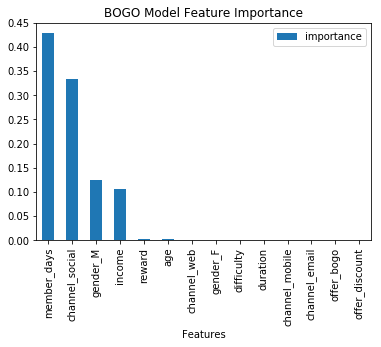

In [142]:
bogo_features = pd.DataFrame(bogo_model.feature_importances_,
                                index= bogo_offer.columns[3:],
                                columns = ['importance'] ).sort_values('importance', ascending = False)
bogo_features.plot.bar()
plt.title('BOGO Model Feature Importance')
plt.xlabel('Features')

Evaluating the main features that predict a customer will take an BOGO offer, I found that the number of days since the registration in the app is the most important feature. We can observe that communicating the offer on social media are crucial to notify these type of customers. Also, we can see that demographic variables like the income, the gender are important to predict if a client will take an offer. Lastly, the offer reward are the least feature but it’s interesting taking into account that this offer gives another exact item.

### c. Discount offer model

In [143]:
drop_cols_prep=['customer_id','offer_id','effective_offer']
features,target=data_prep(discount_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

In [144]:
Grid_Search_param_selection(X_train,y_train)

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 20,
 'min_samples_split': 2,
 'splitter': 'best'}

Use parameters found with GridSearch of DecisionTreeClassifier

In [145]:
discount_model = DecisionTreeClassifier(
                                criterion = 'entropy',
                                 max_depth = 5,
                                 max_features = None,
                                 min_samples_leaf = 20,
                                 min_samples_split = 2,
                                 splitter = 'best'
                              )

In [146]:
run_model(discount_model)

DecisionTreeClassifier trained on 12992 samples.
MSE_train: 0.2089
MSE_test: 0.2090
Training accuracy:0.7911
Test accuracy:0.7910
             precision    recall  f1-score   support

          0     0.7591    0.5167    0.6149      1049
          1     0.8000    0.9218    0.8566      2200

avg / total     0.7868    0.7910    0.7785      3249



,DecisionTreeClassifier
testing_score,0.791013
training_score,0.791102


In [147]:
discount_model.get_params()

{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 20,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

Text(0.5,0,'Features')

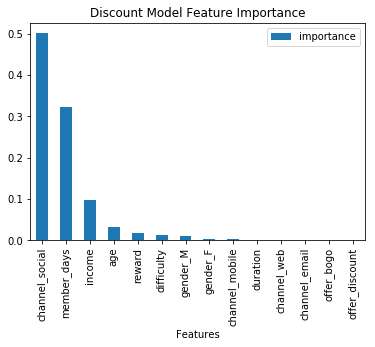

In [148]:
discount_features = pd.DataFrame(discount_model.feature_importances_,
                                index= discount_offer.columns[3:],
                                columns = ['importance'] ).sort_values('importance', ascending = False)
discount_features.plot.bar()
plt.title('Discount Model Feature Importance')
plt.xlabel('Features')

Now, looking at prediction of discount offer, we can see sligth changes. The social media communication is even more important here, and the antiquity is the second most important feature. Also we can see the income, reward and gender features. But we can see too mobile channel communication, so as the customer age and the offer difficulty, which is the transaction minimun amount to get the offer. In this case we can see that importance is distributed in more features than BOGO model.

### d. Informational offer model

In [149]:
drop_cols_prep=['customer_id','offer_id','effective_offer']
features,target=data_prep(informational_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

In [150]:
Grid_Search_param_selection(X_train,y_train)

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 20,
 'min_samples_split': 2,
 'splitter': 'best'}

Use parameters found with GridSearch of DecisionTreeClassifier

In [151]:
informational_model = DecisionTreeClassifier(
                                criterion = 'entropy',
                                 max_depth = 5,
                                 max_features = None,
                                 min_samples_leaf = 20,
                                 min_samples_split = 2,
                                 splitter = 'best'
                              )

In [152]:
run_model(informational_model)

DecisionTreeClassifier trained on 8108 samples.
MSE_train: 0.3162
MSE_test: 0.3222
Training accuracy:0.6838
Test accuracy:0.6778
             precision    recall  f1-score   support

          0     0.6682    0.6108    0.6382       943
          1     0.6850    0.7362    0.7096      1084

avg / total     0.6772    0.6778    0.6764      2027



,DecisionTreeClassifier
testing_score,0.677849
training_score,0.683769


In [153]:
informational_model.feature_importances_

array([ 0.05152401,  0.28344514,  0.00094653,  0.        ,  0.23749224,
        0.        ,  0.        ,  0.        ,  0.42659208,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [154]:
informational_offer.columns[3:]

Index(['age', 'income', 'gender_F', 'gender_M', 'member_days', 'difficulty',
       'duration', 'reward', 'channel_social', 'channel_web', 'channel_mobile',
       'channel_email', 'offer_bogo', 'offer_discount'],
      dtype='object')

Text(0.5,0,'Features')

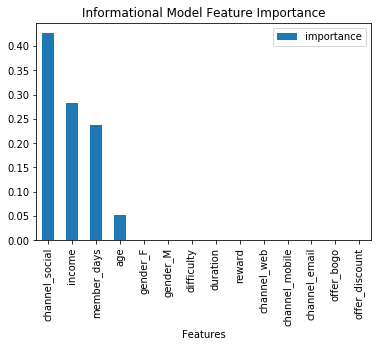

In [155]:
informational_features = pd.DataFrame(informational_model.feature_importances_,
                                index= informational_offer.columns[3:],
                                columns = ['importance'] ).sort_values('importance', ascending = False)
informational_features.plot.bar()
plt.title('Informational Model Feature Importance')
plt.xlabel('Features')

Finally, if we look the prediction of the informational offer, there are less features than the previous two models. Nevertheless, we can see that customer Income, days since their registration are the features that are present in the three models. Those two features are the common factor to predict if any client could take an offer in the app. Also we can watch in the graph that web channel is very important if we want to advertise only about buying in the coffee.

## 9. Conclusions

This project was an end to end solution. First of all we pointed one question to solve having three related datasets. In the process we cleaned, wrangled and made feature engineering of the data to solve the question. After this we trained three supervised clasiffication models to get the most important features which explains the customer completed the offer that recieved days before.

The customer income and antiquity are crucial to predict if they are going to take an offer. According to the offer type, we need to publish the offer in different channels; social medial are the best for BOGO and discount, but web works better with informational offers. Mobile channel are important for discount offer to. So the marketing behind this offers needs to be communicated through digital channels. In addition, features like the customer age or gender could be crucial to predit the offer use. On the other hand, the difficulty and reward are also important to atract the customer attention.

In relation with this project, one of the main difficulties was to work with the data to response the main aswer. As normally I didn´t work with an time series event dataframe, to ordern and label all the possible scenarios was an true challenge. I want to thank Udacity to help me to get through this Nanodegree. This has been really hard but gratefull and has develop many new skills.

We can Observe that parameters for each offer type model

In [168]:
params_bogo = bogo_model.get_params()
params_discount = discount_model.get_params()
params_informational = informational_model.get_params()

df1 = pd.DataFrame(list(params_bogo.items()), columns=['Item', 'BOGO'])
df2 = pd.DataFrame(list(params_discount.items()), columns=['Item', 'Discount'])
df3 = pd.DataFrame(list(params_informational.items()), columns=['Item', 'Informational'])

pd.merge(pd.merge(df1,df2, on = 'Item'), df3, on='Item').set_index('Item')

,BOGO,Discount,Informational
Item,,,
class_weight,None,None,None
criterion,gini,entropy,entropy
max_depth,5,5,5
max_features,None,None,None
max_leaf_nodes,None,None,None
min_impurity_decrease,0,0,0
min_impurity_split,None,None,None
min_samples_leaf,20,20,20
min_samples_split,2,2,2


Finally, we compare the performance of each model

In [188]:
bogo_perf = run_model(bogo_model)
bogo_perf.rename(columns = {'DecisionTreeClassifier':'BOGO'}, inplace = True)
bogo_perf = bogo_perf.reset_index()

discount_perf = run_model(discount_model)
discount_perf.rename(columns = {'DecisionTreeClassifier':'Discount'}, inplace = True)
discount_perf = discount_perf.reset_index()

informational_perf = run_model(informational_model)
informational_perf.rename(columns = {'DecisionTreeClassifier':'Informational'}, inplace = True)
informational_perf =informational_perf.reset_index()

pd.merge(pd.merge(bogo_perf,discount_perf, on='index'),informational_perf, on='index').set_index(keys='index')

DecisionTreeClassifier trained on 8108 samples.
MSE_train: 0.3310
MSE_test: 0.3409
Training accuracy:0.6690
Test accuracy:0.6591
             precision    recall  f1-score   support

          0     0.6394    0.6129    0.6259       943
          1     0.6750    0.6993    0.6869      1084

avg / total     0.6584    0.6591    0.6585      2027

DecisionTreeClassifier trained on 8108 samples.
MSE_train: 0.3162
MSE_test: 0.3222
Training accuracy:0.6838
Test accuracy:0.6778
             precision    recall  f1-score   support

          0     0.6682    0.6108    0.6382       943
          1     0.6850    0.7362    0.7096      1084

avg / total     0.6772    0.6778    0.6764      2027

DecisionTreeClassifier trained on 8108 samples.
MSE_train: 0.3162
MSE_test: 0.3222
Training accuracy:0.6838
Test accuracy:0.6778
             precision    recall  f1-score   support

          0     0.6682    0.6108    0.6382       943
          1     0.6850    0.7362    0.7096      1084

avg / total     0.6772

,BOGO,Discount,Informational
index,,,
testing_score,0.659102,0.677849,0.677849
training_score,0.668969,0.683769,0.683769
